In [104]:
import pandas as pd 
import numpy as np

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config


In [105]:
PATH = "./clusters.csv"

churn = pd.read_csv(PATH)
class_name = 'cluster'

churn.rename(columns = {'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1':'class 1'}, inplace = True)
churn.rename(columns = {'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2':'class 2'}, inplace = True)
churn.drop(['class 1', 'class 2','CLIENTNUM','Unnamed: 0', 'Attrition_Flag'], axis=1, inplace=True)
churn[class_name] = churn[class_name].replace([0.0, 1.0,2.0 ], ['cluster 1', 'cluster 2', 'cluster 3'])
print(churn.columns)
churn = churn.dropna()

print(churn[class_name].value_counts())

X = churn.drop(class_name,axis=1)
y = churn[class_name]


Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'cluster'],
      dtype='object')
cluster 2    3325
cluster 3    2700
cluster 1    1056
Name: cluster, dtype: int64


<AxesSubplot: ylabel='cluster'>

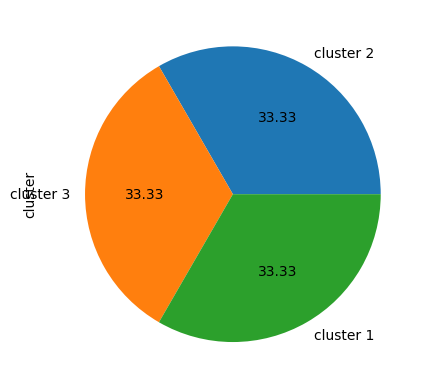

In [106]:
   
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

ros = RandomOverSampler(sampling_strategy="not majority")
X_train, y_train = ros.fit_resample(X_train, y_train)

y_train.value_counts().plot.pie(autopct='%.2f')

In [122]:


cat_cols = ['Gender', 'Education_Level','Card_Category', 'Income_Category']
int_cols = churn.drop(cat_cols, axis=1).columns

classifier = [
    KNeighborsClassifier(5),
    GaussianNB(),
    DecisionTreeClassifier(max_depth=6)
]

set_config(transform_output="pandas")

for model in classifier : 

    cat_cols = ['Gender', 'Education_Level','Card_Category', 'Income_Category', 'Marital_Status']
    int_cols = X.drop(cat_cols, axis=1).columns



    preprocess = ColumnTransformer(
        [
        ("Scaling", StandardScaler(), int_cols),
        ("OneHot", OneHotEncoder(sparse_output=False), cat_cols)
        ]
    )

    steps = [
        ("preprocess" , preprocess),
        ("model", model)
    ]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    score = pipe.score(X_test,y_test)

    print(f"the {model} has a score of {score}")

    

the KNeighborsClassifier() has a score of 0.3461321287408244
the GaussianNB() has a score of 0.16487859966120835
the DecisionTreeClassifier(max_depth=6) has a score of 0.4059853190287973


Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')


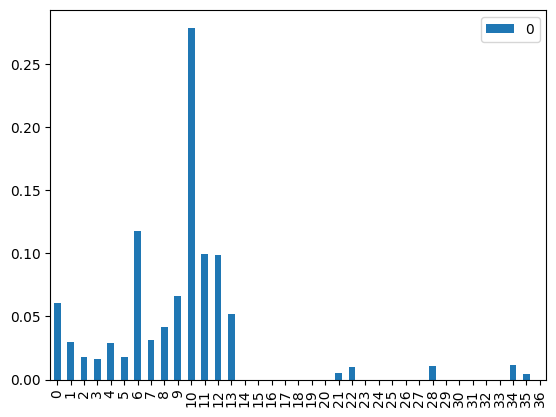

In [124]:
features_names = X.columns
feature_importance = pd.DataFrame(pipe.steps[1][1].feature_importances_)
#features = list(feature_importance[[0]>0].index)
feature_importance.plot(kind='bar')
print(X.columns)

In [126]:

cat_cols = ['Gender', 'Education_Level','Card_Category', 'Income_Category', 'Marital_Status']
int_cols = X.drop(cat_cols, axis=1).columns

param_grid = { 
    'max_features': ['sqrt', 'log2',None],
    'max_depth' : [7,8,9,10],
    'criterion' :['gini', 'entropy'],
}

DecisionTreeClassifier(random_state=42)

dtc = RandomizedSearchCV(model,
                  param_grid,
                  cv=5,
                  n_iter=20,
                  random_state=42,
)

preprocess = ColumnTransformer(
        [
        ("Scaling", StandardScaler(), int_cols),
        ("OneHot", OneHotEncoder(sparse_output=False), cat_cols)
        ]
    )

steps = [
        ("preprocess" , preprocess),
        ("Randomized", dtc)
    ]

pipe = Pipeline(steps)

pipe.fit(X_train,y_train)
print(dtc.best_params_)
print(dtc.best_score_)

{'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}
0.5079508471961303
